In [1]:
using ParallelTemperingMonteCarlo
using DelimitedFiles, BenchmarkTools,StaticArrays
import ParallelTemperingMonteCarlo.Multihistogram.initialise, ParallelTemperingMonteCarlo.Multihistogram.systemsolver
using Plots

The goal of this notebook is implementing the temperature dependent entropy, defined as $S_T = \frac{U}{T} + k\textnormal{ln}(Z)$

In [11]:
list =[-1.8187233512       -0.4312887551       -1.0407964208
-1.2984764759        1.6563650916       -0.3840305280
-1.8032563526        0.0882846359        1.1478408156
-0.9400285245       -1.8683525361        0.4501901263
-0.1232633899        0.6688587630       -2.0284231112
 0.0982689768       -1.5095376061       -1.5128468587
-0.0982490824        1.5095340614        1.5128450736
 0.9400322000        1.8683478540       -0.4501796219
 1.2984783869       -1.6563562578        0.3840360573
 0.1232835007       -0.6688519385        2.0284192039
 1.8032655246       -0.0882782646       -1.1478181497
 1.8187138065        0.4312856349        1.0407891901
-1.5702724374        0.6171239233       -0.7177487839
-1.3897066652       -1.1584302821       -0.2975152358
-0.8666704643       -0.9776793610       -1.2863840832
-0.9782659161        0.1196730822       -1.5461022703
-1.8245528826       -0.1727868768        0.0539217218
-0.0125911130       -0.4234865501       -1.7838917977
-1.3819128820       -0.8966975430        0.8049964078
 0.7035994285       -1.5948004173       -0.5686303495
-1.5624787986        0.8788549469        0.3847631473
 0.4114387601        1.2781028076       -1.2485801098
-0.9578726658        0.8048919292        1.3403020290
-0.8462767302       -0.2924586427        1.6000199864
 0.1805659338       -1.7755506532        0.4202326063
-0.1805649527        1.7755509225       -0.4202316409
 0.8462894232        0.2924622119       -1.6000123515
-0.7161949291        1.1713145619       -1.2152587150
 0.9578846395       -0.8048887500       -1.3402948294
-0.4240339776       -1.7015895288       -0.5353079453
-0.4114334905       -1.2780996479        1.2485840790
-0.7035948602        1.5948002185        0.5686341181
 1.8245417184        0.1727873937       -0.0539133522
 0.4240380245        1.7015817409        0.5353075027
 0.7161980919       -1.1713070962        1.2152540500
 0.9782665992       -0.1196720587        1.5460873190
 0.8666714337        0.9776717013        1.2863712951
 1.5624773781       -0.8788469380       -0.3847507544
 1.3819130548        0.8966959439       -0.8049802706
 0.0126100329        0.4234868072        1.7838835264
 1.3896961766        1.1584208717        0.2975161230
 1.5702604256       -0.6171179920        0.7177448084
-0.0000141498       -0.0000033511       -0.0000080864
-0.8930013201       -0.2117646508       -0.5110355818
-0.6375602523        0.8132770362       -0.1885632314
-0.4615616402       -0.9173661279        0.2210406165
-0.8854087184        0.0433462786        0.5635878731
 0.0482436911       -0.7411872721       -0.7428140624
-0.0605291885        0.3284093880       -0.9959629822
 0.8929876559        0.2117611144        0.5110271539
 0.6375485541       -0.8132798440        0.1885576110
 0.4615500194        0.9173639515       -0.2210457346
-0.0482510105        0.7411849444        0.7428075465
 0.8854004844       -0.0433475039       -0.5635896356
 0.0605223003       -0.3284113710        0.9959565058]
 
ico_55 = []
 for row in eachrow(list)
    ix = SVector{3}(row)
    push!(ico_55,ix)
 end 


In [14]:
n_atoms = 55

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details

mc_cycles = 400000 #default 20% equilibration cycles on top

mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom


#convert to Bohr
AtoBohr = 1.8897259886
pos_ne55 = ico_55 * AtoBohr*2.782

length(pos_ne55) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne55 = SphericalBC(radius=8. *AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne55, bc_ne55)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

In [15]:
ptmc_run!(mc_states, move_strat, mc_params, pot, ensemble, results; save_ham = false)

Total number of moves per MC cycle: 55



equilibration done


MC loop done.
[0.0014533448183490208, 0.001542862471755482, 0.0015868404956007772, 0.0016832743379634975, 0.00176346304559382, 0.001829311202851829, 0.001929504718453178, 0.001987315763607327, 0.0020837190856696094, 0.0021916935418767373, 0.0023506057629747094, 0.002430886440472353, 0.0025832591215630874, 0.002700790716533575, 0.0028434266311856485, 0.00297903408863469, 0.0031449552014722842, 0.003357046875483929, 0.003585515752789746, 0.003760352563070925, 0.00409996290136118, 0.004499352037880197, 0.005336837241173211, 0.0071865154656223324, 0.01690570613498677, 0.03206872296669642, 0.014082209477498714, 0.008854093614272975, 0.008565734983709758, 0.008641425649089415, 0.009193905192921752, 0.009636886392079696]
done


In [16]:
HistArray,energyvector,beta,nsum,NTraj,NBins,kB = initialise(results,temp)
alpha,S = systemsolver(HistArray,energyvector,beta,nsum,NTraj,NBins)

B Vector Calculated
A Matrix Calculated
system solved!
Entropy Found


([2831.843633010811, 2909.369460182173, 2983.908680832308, 3055.5715127609756, 3124.4632046347338, 3190.6854713520643, 3254.3363316700934, 3315.509355150402, 3374.2954819256897, 3430.7811695454416  …  3989.4972563717574, 4021.124063997945, 4051.239656564908, 4079.321002718229, 4105.241817170799, 4129.651302222699, 4152.859247177892, 4174.957074608684, 4195.991319782803, 4216.0], Any[-4981.9219665804385, -4968.801305711135, -4957.663865591379, -4947.69416676924, -4938.645670508168, -4930.399121646637, -4922.816656366939, -4915.7966854043325, -4909.265030378239, -4903.150834036701  …  -4692.980294890163, -4690.959255628101, -4688.927783557035, -4686.956869254382, -4685.085497396013, -4683.348668660257, -4681.318320278982, -4679.52658800642, -4677.558376757225, -4675.3182317925475])

Having entropy and the solved alpha, we proceed as normal to find the partition function

In [17]:
dT = (last(temp.t_grid) - first(temp.t_grid))/400
T = [(i-1)*dT + first(temp.t_grid) for i = 1:400]
   #Initialise all relevant vectors
y = Array{Float64}(undef,400,NBins)
XP = Array{Float64}(undef,400,NBins)
nexp = 0
Z = Array{Float64}(undef,400)
U = Array{Float64}(undef,400)
U2 = Array{Float64}(undef,400)
Cv = Array{Float64}(undef,400)

400-element Vector{Float64}:
       3.796977484509763e-58
       1.849600684866807e-130
       4.614947368131486e-270
       5.2871254379366556e-294
 -237678.01617275213
       5.305693459673002e-168
       3.1660504659949366e-294
       4.406922907332529e-91
       2.7385717854160672e-86
       4.383564673107158e-58
       ⋮
       0.0
       0.0
       0.0
       0.0
       0.0
       0.0
       0.0
       0.0
       0.0

In [18]:
for i = 1:400
    #y is a matrix of free energy
    y[i,:] = S[:] .- energyvector[:]./(T[i]*kB)
    #here we set the zero of free energy

  

    #count=0  this variable was included for bug testing and should be excluded from the main program

    #below we calculate the partition function
    
    @label start
    XP[i,:] = exp.(y[i,:].-nexp)
    Z[i] = sum(XP[i,:] )
    
    #this loop exists to make sure the scale of our partition function is sensible
    #the numbers are utterly arbitrary, they have been chosen so that they don't create a loop
     
     if Z[i] < 1.
         #count += 1

         nexp -= 1.  
         @goto start
     elseif Z[i] > 100.

         #count += 1
         nexp += 0.7

         @goto start
     end
end

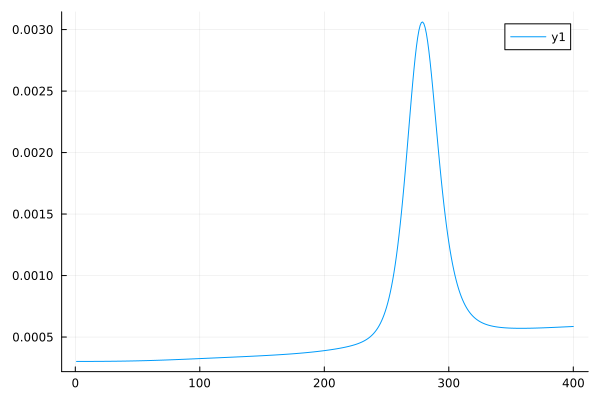

In [19]:
for i=1:400
    U[i] = sum(XP[i,:].*energyvector[:])/Z[i]
    U2[i] = sum(XP[i,:].*energyvector[:].*energyvector[:])/Z[i]
    Cv[i] = (U2[i] - U[i]*U[i])/kB/(T[i]^2)
end
plot(Cv)


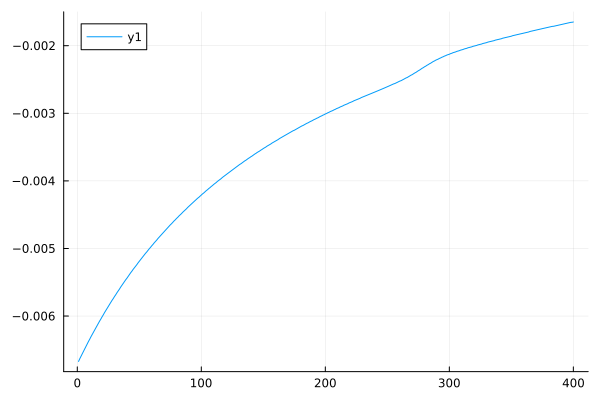

In [20]:
S_T = Array{Float64}(undef,400)

for i = 1:400
    S_T[i] = U[i]/T[i] + kB*log(Z[i])
end
plot(S_T)